In [285]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import statsmodels.api as sm
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet,HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

df_train = pd.read_csv('train.csv')
df_train.drop(['Id'],axis=1,inplace=True)
df_test = pd.read_csv('test.csv')

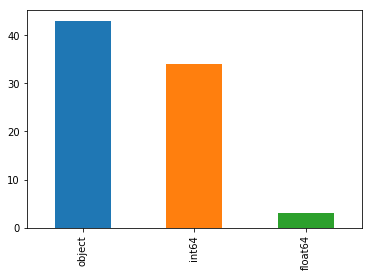

In [286]:
count = pd.value_counts(df_train.dtypes)
count.plot.bar()
plt.show()

## On this dataset we try to predict SalePrice. So let's analyze it:

In [287]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

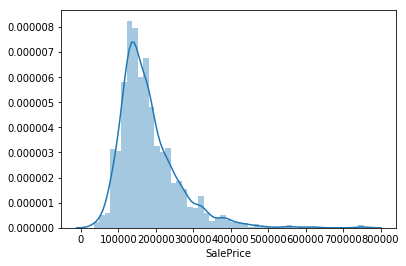

In [288]:
sns.distplot(df_train['SalePrice'])

## Checking for missing values

In [289]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


## Let's analyze these missing values based on data_description.txt

# Some data has levels from Poor to Exc. Can we change Poor to 1 and Exc to 5? Just as OveralQual does.

## PoolQC: Pool quality	
   - Ex  Excellent
   - Gd	Good
   - TA	Average/Typical
   - Fa	Fair
   - NA	No Pool

In [290]:
df_train.PoolQC.fillna('None',inplace=True)
df_train.loc[df_train.PoolQC=='Ex','PoolQC'] = 4
df_train.loc[df_train.PoolQC=='Gd','PoolQC'] = 3
df_train.loc[df_train.PoolQC=='Ta','PoolQC'] = 2
df_train.loc[df_train.PoolQC=='Fa','PoolQC'] = 1
df_train.loc[df_train.PoolQC=='None','PoolQC'] = 0

## MiscFeature: Miscellaneous feature not covered in other categories
   - Elev: Elevator
   - Gar2: 2nd Garage (if not described in garage section)
   - Othr: Other
   - Shed: Shed (over 100 SF)
   - TenC: Tennis Court
   - NA: None
    

In [291]:
print(df_train['MiscFeature'].notnull().sum())
df_train.MiscFeature.fillna('None',inplace=True)

54


## Alley: Type of alley access to property
- Grvl:	Gravel
- Pave:	Paved
- NA: 	No alley access

In [292]:
print(df_train['Alley'].notnull().sum())
df_train.Alley.fillna('None',inplace=True)

91


## Fence: Fence quality
- GdPrv:	Good Privacy
- MnPrv:	Minimum Privacy
- GdWo:	Good Wood
- MnWw:	Minimum Wood/Wire
- NA:	No Fence

In [293]:
print(df_train['Fence'].notnull().sum())
df_train.Fence.fillna('None',inplace=True)

281


## FireplaceQu: Fireplace quality
- Ex:	Excellent - Exceptional Masonry Fireplace
- Gd:	Good - Masonry Fireplace in main level
- TA:	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
- Fa:	Fair - Prefabricated Fireplace in basement
- Po:	Poor - Ben Franklin Stove
- NA:	No Fireplace

In [294]:
print(df_train['FireplaceQu'].notnull().sum())
df_train.FireplaceQu.fillna('None',inplace=True)
df_train.loc[df_train.FireplaceQu=='Ex','FireplaceQu'] = 5
df_train.loc[df_train.FireplaceQu=='Gd','FireplaceQu'] = 4
df_train.loc[df_train.FireplaceQu=='TA','FireplaceQu'] = 3
df_train.loc[df_train.FireplaceQu=='Fa','FireplaceQu'] = 2
df_train.loc[df_train.FireplaceQu=='Po','FireplaceQu'] = 1
df_train.loc[df_train.FireplaceQu=='None','FireplaceQu'] = 0

770


## LotFrontage: Linear feet of street connected to property


In [295]:
def fill_missing_LotFrontage(df):
    
    #Feature set
    lotFrontage_df = df[['LotFrontage','LotArea','OverallQual','MSSubClass','TotalBsmtSF','1stFlrSF','GrLivArea','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageArea','SalePrice']]
    # Split sets into train and test
    train  = lotFrontage_df.loc[ (df.LotFrontage.notnull()) ]# known Age values
    test = lotFrontage_df.loc[ (df.LotFrontage.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedLotFrontage = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[(df.LotFrontage.isnull()), 'LotFrontage'] = predictedLotFrontage
    
    return df
df_train = fill_missing_LotFrontage(df_train)

## GarageYrBlt: Year garage was built


In [296]:
#Exterior1st, Exterior2nd,ExterQual, Foundation, BsmtQual, GarageFinish,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageCars,GarageArea,GarageQual,GarageCond,EnclosedPorch,SalePrice
def fill_missing_age(df):
    #Feature set
    age_df = df[['GarageYrBlt','OverallQual','OverallCond','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','GarageCars','GarageArea','EnclosedPorch','SalePrice']]
    # Split sets into train and test
    train  = age_df.loc[ (df.GarageYrBlt.notnull()) ]# known Age values
    test = age_df.loc[ (df.GarageYrBlt.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.GarageYrBlt.isnull()), 'GarageYrBlt' ] = predictedAges 
    
    return df
df_train = fill_missing_age(df_train)
df_train.shape

(1460, 80)

## GarageQual: Garage quality
- Ex:	Excellent
- Gd:	Good
- TA:	Typical/Average
- Fa:	Fair
- Po:	Poor
- NA:	No Garage

In [297]:
print(df_train['GarageQual'].notnull().sum())
df_train.GarageQual.fillna('None',inplace=True)
df_train.loc[df_train.GarageQual=='Ex','GarageQual'] = 5
df_train.loc[df_train.GarageQual=='Gd','GarageQual'] = 4
df_train.loc[df_train.GarageQual=='TA','GarageQual'] = 3
df_train.loc[df_train.GarageQual=='Fa','GarageQual'] = 2
df_train.loc[df_train.GarageQual=='Po','GarageQual'] = 1
df_train.loc[df_train.GarageQual=='None','GarageQual'] = 0

1379


## GarageFinish: Interior finish of the garage
- Fin	Finished
- RFn	Rough Finished	
- Unf	Unfinished
- NA	No Garage

In [298]:
print(df_train['GarageFinish'].notnull().sum())
df_train.GarageFinish.fillna('None',inplace=True)

1379


## GarageType: Garage location
- 2Types	More than one type of garage
- Attchd	Attached to home
- Basment	Basement Garage
- BuiltIn	Built-In (Garage part of house - typically has room above garage)
- CarPort	Car Port
- Detchd	Detached from home
- NA	No Garage

In [299]:
print(df_train['GarageType'].notnull().sum())
df_train.GarageType.fillna('None',inplace=True)

1379


## GarageCond: Garage condition
- Ex:	Excellent
- Gd:	Good
- TA:	Typical/Average
- Fa:	Fair
- Po:	Poor
- NA:	No Garage

In [300]:
print(df_train['GarageCond'].notnull().sum())
df_train.GarageCond.fillna('None',inplace=True)
df_train.loc[df_train.GarageCond=='Ex','GarageCond'] = 5
df_train.loc[df_train.GarageCond=='Gd','GarageCond'] = 4
df_train.loc[df_train.GarageCond=='TA','GarageCond'] = 3
df_train.loc[df_train.GarageCond=='Fa','GarageCond'] = 2
df_train.loc[df_train.GarageCond=='Po','GarageCond'] = 1
df_train.loc[df_train.GarageCond=='None','GarageCond'] = 0

1379


## BsmtFinType2: Rating of basement finished area (if multiple types)
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

In [301]:
print(df_train['BsmtFinType2'].notnull().sum())
df_train.BsmtFinType2.fillna('None',inplace=True)
df_train.loc[df_train.BsmtFinType2=='GLQ','BsmtFinType2'] = 6
df_train.loc[df_train.BsmtFinType2=='ALQ','BsmtFinType2'] = 5
df_train.loc[df_train.BsmtFinType2=='BLQ','BsmtFinType2'] = 4
df_train.loc[df_train.BsmtFinType2=='Rec','BsmtFinType2'] = 3
df_train.loc[df_train.BsmtFinType2=='LwQ','BsmtFinType2'] = 2
df_train.loc[df_train.BsmtFinType2=='Unf','BsmtFinType2'] = 1
df_train.loc[df_train.BsmtFinType2=='None','BsmtFinType2'] = 0

1422


## 	BsmtExposure: Refers to walkout or garden level walls
- Gd	Good Exposure
- Av	Average Exposure (split levels or foyers typically score average or above)	
- Mn	Mimimum Exposure
- No	No Exposure
- NA	No Basement

In [302]:
print(df_train['BsmtExposure'].notnull().sum())
df_train.BsmtExposure.fillna('None',inplace=True)
df_train.loc[df_train.BsmtExposure=='Gd','BsmtExposure'] = 4
df_train.loc[df_train.BsmtExposure=='Av','BsmtExposure'] = 3
df_train.loc[df_train.BsmtExposure=='Mn','BsmtExposure'] = 2
df_train.loc[df_train.BsmtExposure=='No','BsmtExposure'] = 1
df_train.loc[df_train.BsmtExposure=='None','BsmtExposure'] = 0

1422


## BsmtCond: Evaluates the general condition of the basement
- Ex:	Excellent
- Gd:	Good
- TA:	Typical - slight dampness allowed
- Fa:	Fair - dampness or some cracking or settling
- Po:	Poor - Severe cracking, settling, or wetness
- NA:	No Basement

In [303]:
print(df_train['BsmtCond'].notnull().sum())
df_train.BsmtCond.fillna('None',inplace=True)
df_train.loc[df_train.BsmtCond=='Ex','BsmtCond'] = 5
df_train.loc[df_train.BsmtCond=='Gd','BsmtCond'] = 4
df_train.loc[df_train.BsmtCond=='TA','BsmtCond'] = 3
df_train.loc[df_train.BsmtCond=='Fa','BsmtCond'] = 2
df_train.loc[df_train.BsmtCond=='Po','BsmtCond'] = 1
df_train.loc[df_train.BsmtCond=='None','BsmtCond'] = 0

1423


## BsmtFinType1: Rating of basement finished area
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

In [304]:
print(df_train['BsmtFinType1'].notnull().sum())
df_train.BsmtFinType1.fillna('None',inplace=True)
df_train.loc[df_train.BsmtFinType1=='GLQ','BsmtFinType1'] = 6
df_train.loc[df_train.BsmtFinType1=='ALQ','BsmtFinType1'] = 5
df_train.loc[df_train.BsmtFinType1=='BLQ','BsmtFinType1'] = 4
df_train.loc[df_train.BsmtFinType1=='Rec','BsmtFinType1'] = 3
df_train.loc[df_train.BsmtFinType1=='LwQ','BsmtFinType1'] = 2
df_train.loc[df_train.BsmtFinType1=='Unf','BsmtFinType1'] = 1
df_train.loc[df_train.BsmtFinType1=='None','BsmtFinType1'] = 0

1423


## BsmtQual: Evaluates the height of the basement
- Ex	Excellent (100+ inches)	
- Gd	Good (90-99 inches)
- TA	Typical (80-89 inches)
- Fa	Fair (70-79 inches)
- Po	Poor (<70 inches)
- NA	No Basement

In [305]:
print(df_train['BsmtQual'].notnull().sum())
df_train.BsmtQual.fillna('None',inplace=True)
df_train.loc[df_train.BsmtQual=='Ex','BsmtQual'] = 5
df_train.loc[df_train.BsmtQual=='Gd','BsmtQual'] = 4
df_train.loc[df_train.BsmtQual=='TA','BsmtQual'] = 3
df_train.loc[df_train.BsmtQual=='Fa','BsmtQual'] = 2
df_train.loc[df_train.BsmtQual=='Po','BsmtQual'] = 1
df_train.loc[df_train.BsmtQual=='None','BsmtQual'] = 0

1423


## MasVnrType: Masonry veneer type
- BrkCmn	Brick Common
- BrkFace	Brick Face
- CBlock	Cinder Block
- None	None
- Stone	Stone

In [306]:
df_train.MasVnrType.fillna('None',inplace=True)

## MasVnrArea: Masonry veneer area in square feet

In [307]:
def fill_missing_MasVnrArea(df):
    
    #Feature set
    age_df = df[['MasVnrArea','LotFrontage','OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtQual','BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','SalePrice','MasVnrType']]
    age_df = pd.get_dummies(age_df)
    # Split sets into train and test
    train  = age_df.loc[ (df.MasVnrArea.notnull()) ]# known Age values
    test = age_df.loc[ (df.MasVnrArea.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.MasVnrArea.isnull()), 'MasVnrArea' ] = predictedAges 
    
    return df
df_train = fill_missing_MasVnrArea(df_train)

## Electrical: Electrical system
- SBrkr	Standard Circuit Breakers & Romex
- FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
- Mix	Mixed

## Because there is only 1 value missing, and we won't predict the value we will drop this row.

In [308]:
df_train.dropna(subset=['Electrical'],inplace=True)

## Analyzing features

In [309]:
df_train['TotalConstrSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] + df_train['TotalBsmtSF']
df_train.drop(['1stFlrSF','2ndFlrSF','TotalBsmtSF'],axis=1,inplace=True)

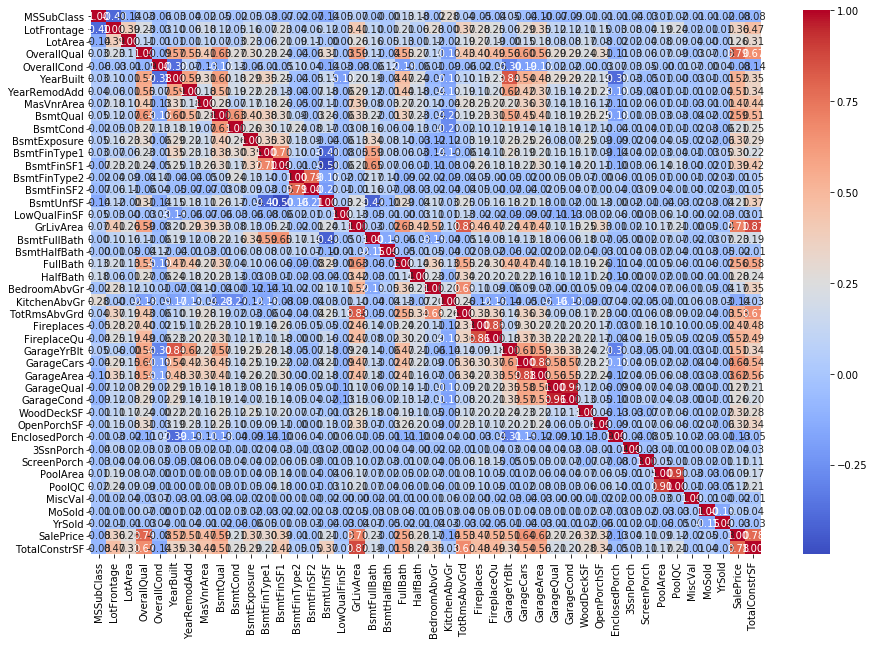

In [310]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Transforming some numerical variables that are really categorical

In [311]:
# Does not have Po
df_train.loc[df_train.KitchenQual=='Ex','KitchenQual'] = 4
df_train.loc[df_train.KitchenQual=='Gd','KitchenQual'] = 3
df_train.loc[df_train.KitchenQual=='TA','KitchenQual'] = 2
df_train.loc[df_train.KitchenQual=='Fa','KitchenQual'] = 1

# # Does not have Po
df_train.loc[df_train.ExterQual=='Ex','ExterQual'] = 4
df_train.loc[df_train.ExterQual=='Gd','ExterQual'] = 3
df_train.loc[df_train.ExterQual=='TA','ExterQual'] = 2
df_train.loc[df_train.ExterQual=='Fa','ExterQual'] = 1

df_train.loc[df_train.ExterCond=='Ex','ExterCond'] = 4
df_train.loc[df_train.ExterCond=='Gd','ExterCond'] = 3
df_train.loc[df_train.ExterCond=='TA','ExterCond'] = 2
df_train.loc[df_train.ExterCond=='Fa','ExterCond'] = 1
df_train.loc[df_train.ExterCond=='Po','ExterCond'] = 0

df_train.loc[df_train.HeatingQC=='Ex','HeatingQC'] = 4
df_train.loc[df_train.HeatingQC=='Gd','HeatingQC'] = 3
df_train.loc[df_train.HeatingQC=='TA','HeatingQC'] = 2
df_train.loc[df_train.HeatingQC=='Fa','HeatingQC'] = 1
df_train.loc[df_train.HeatingQC=='Po','HeatingQC'] = 0


## Dropping columns with low correlation with SalePrice and/or with other Features

In [312]:
ar = ['MSSubClass','BsmtFinSF2','OverallCond','MiscVal','LowQualFinSF','KitchenAbvGr','BsmtHalfBath','SaleCondition',
    'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','YrSold','MoSold','BsmtCond','LotArea','LotFrontage',
    'OpenPorchSF','WoodDeckSF','ExterCond','BsmtFinType2','Functional','Fence','BsmtExposure','LandSlope','LotShape','LandContour',
    'LotConfig','RoofStyle','SaleType']
df_train.drop(ar,axis=1,inplace=True)

## Outliers

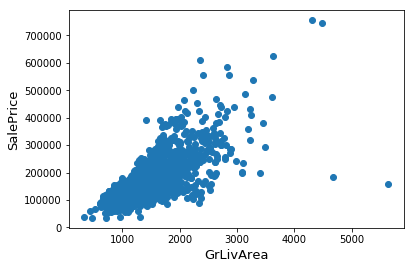

In [313]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [314]:
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index,inplace=True)

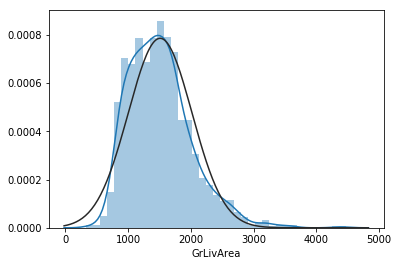

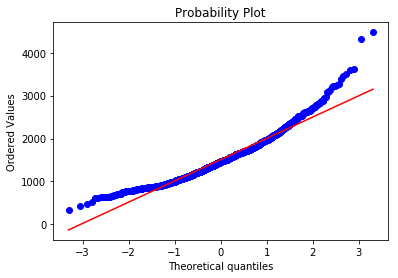

In [315]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

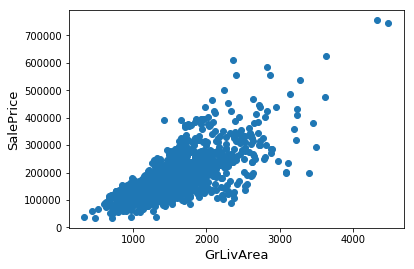

In [316]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Normalization and Skewed Features

### Skewed Features

In [317]:
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MasVnrArea,2.692507
SalePrice,1.878426
GrLivArea,1.009196
BsmtUnfSF,0.918998
ExterQual,0.818128
TotalConstrSF,0.802685
BsmtFinSF1,0.763177
HalfBath,0.681432
TotRmsAbvGrd,0.660262
Fireplaces,0.630414


In [318]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

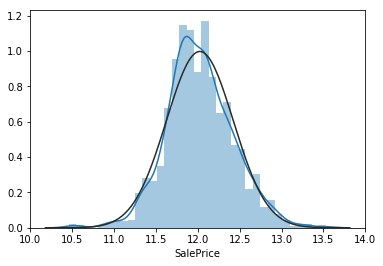

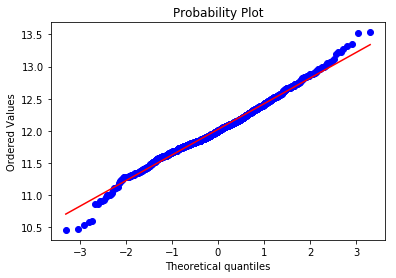

In [319]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [320]:
def getClassifierWithHighestAccuracy():
    classifiers = [
    LogisticRegression()]
    models = pd.DataFrame({'Model':[],'Score':[]})
    i=0
    greater = 0
    alg = ''
    for clas in classifiers:
        print(clas.__class__.__name__)
        score = cross_val_score(clas,X_trainval,Y_trainval,cv=5)
        models.loc[i]=[clas.__class__.__name__,str(np.mean(score)*100)+' %']
        if np.mean(score) > greater:
            greater = np.mean(score)
            alg = clas
        print(np.mean(score))
        i+=1
    print('Predictions using Mean on cross validation:')
    print(models.sort_values(by=['Score'],ascending=False))
    return alg

In [325]:
# response= df_train.SalePrice
# df_train.drop(['SalePrice'],axis=1,inplace=True)
# df_train = pd.get_dummies(df_train,drop_first=True)

X_trainval, X_test, Y_trainval, Y_test = train_test_split(df_train, response,random_state=0)
lr = LinearRegression()
lasso = Lasso(alpha =0.0005, random_state=0).fit(X_trainval,Y_trainval)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
perceptron = GradientBoostingRegressor(loss='huber')
t = ExtraTreesRegressor(n_estimators=1000)
#Ridge = 14, 88.81
#Lasso = 0.0009,88.88
best = 0 
ridge = Ridge(alpha=14)
score = cross_val_score(lr,X_trainval,Y_trainval,cv=5)
print(np.mean(score))
# rmsle(Y_test.values,lasso.predict(X_test))

0.8709177734546794


In [ ]:
def rmsle(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

## Preparing test dataset

# @TODO

In [ ]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

In [ ]:
df_test.PoolQC.fillna('None',inplace=True)
df_test.loc[df_test.PoolQC=='Ex','PoolQC'] = 4
df_test.loc[df_test.PoolQC=='Gd','PoolQC'] = 3
df_test.loc[df_test.PoolQC=='Ta','PoolQC'] = 2
df_test.loc[df_test.PoolQC=='Fa','PoolQC'] = 1
df_test.loc[df_test.PoolQC=='None','PoolQC'] = 0


df_test.MiscFeature.fillna('None',inplace=True)
df_test.Alley.fillna('None',inplace=True)
df_test.Fence.fillna('None',inplace=True)

df_test.FireplaceQu.fillna('None',inplace=True)
df_test.loc[df_test.FireplaceQu=='Ex','FireplaceQu'] = 5
df_test.loc[df_test.FireplaceQu=='Gd','FireplaceQu'] = 4
df_test.loc[df_test.FireplaceQu=='TA','FireplaceQu'] = 3
df_test.loc[df_test.FireplaceQu=='Fa','FireplaceQu'] = 2
df_test.loc[df_test.FireplaceQu=='Po','FireplaceQu'] = 1
df_test.loc[df_test.FireplaceQu=='None','FireplaceQu'] = 0

df_test.BsmtCond.fillna('None',inplace=True)
df_test.loc[df_test.BsmtCond=='Ex','BsmtCond'] = 5
df_test.loc[df_test.BsmtCond=='Gd','BsmtCond'] = 4
df_test.loc[df_test.BsmtCond=='TA','BsmtCond'] = 3
df_test.loc[df_test.BsmtCond=='Fa','BsmtCond'] = 2
df_test.loc[df_test.BsmtCond=='Po','BsmtCond'] = 1
df_test.loc[df_test.BsmtCond=='None','BsmtCond'] = 0

df_test.BsmtExposure.fillna('None',inplace=True)
df_test.loc[df_test.BsmtExposure=='Gd','BsmtExposure'] = 4
df_test.loc[df_test.BsmtExposure=='Av','BsmtExposure'] = 3
df_test.loc[df_test.BsmtExposure=='Mn','BsmtExposure'] = 2
df_test.loc[df_test.BsmtExposure=='No','BsmtExposure'] = 1
df_test.loc[df_test.BsmtExposure=='None','BsmtExposure'] = 0

df_test.dropna(subset=['BsmtFinType1'],inplace=True)
df_test.dropna(subset=['BsmtFinType2'],inplace=True)
df_test.dropna(subset=['GarageArea'],inplace=True)
df_test.dropna(subset=['GarageCars'],inplace=True)

In [ ]:
ar = ['MSSubClass','BsmtFinSF2','OverallCond','MiscVal','LowQualFinSF','KitchenAbvGr','BsmtHalfBath','SaleCondition',
    'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','YrSold','MoSold','BsmtCond','LotArea','LotFrontage',
    'OpenPorchSF','WoodDeckSF','ExterCond','BsmtFinType2','Functional','Fence','BsmtExposure','LandSlope','LotShape','LandContour',
    'LotConfig','RoofStyle','SaleType']
df_test.drop(ar,axis=1,inplace=True)